<a href="https://colab.research.google.com/github/quantumseminar/textbook/blob/main/05deeplearning/02activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 活性化関数

これまで単にたし合わせてきた出力値を非線形性と言ってより複雑な関数に変換するための関数を適用します。これを活性化関数（かっせいかかんすう）と言います。

活性化関数にはさまざまな種類がありますが、今回はよく利用されるReLUと呼ばれる活性化関数を適用します。これは、出力が0以下の場合には0となり、0以上の場合には、y=xとなる関数です。

![../img/activation01.jpg](../img/activation01.jpg)

この活性化関数は出力値に適用します。

![../img/activation02.jpg](../img/activation02.jpg)

単一のユニットで実行してみます。yを求めた後に、max関数を利用して、ReLUを表現してみます。


In [2]:
x = 2
w = 3
b = 4

y = w*x + b

#こちらを挿入
ya = max(0, y)
print(y)

10


この場合、出力値が10で正の値ですので、そのまま10が出てきました。同様のことをPyTorchでも行ってみます。

PyTorchの場合、活性化関数の設定ができます。

In [3]:
#ツールを読み込み
import torch
import torch.nn as nn
import torch.nn.functional as F

#入力値xの個数を3に設定
num_input = 1

#ニューロンの数を2に変更
num_neuron = 1

#単体ユニットを作る
fc = nn.Linear(num_input, num_neuron)

#wとbを設定します。今回wは三つ設定します。
fc.weight = nn.Parameter(torch.tensor([[3.]]))
fc.bias = nn.Parameter(torch.tensor([4.]))

#xを決める。今回は1,2,3の三つを入れます。
x = torch.tensor([[2]], dtype=torch.float32)

#yを計算する
y = F.relu(fc(x))
print(y)

tensor([[10.]], grad_fn=<ReluBackward0>)


こちらも同様に10が得られました。

# ディープニューラルネットワーク
これまでの活性化関数を含む計算を複数レイヤー繋げて行うとディープニューラルネットワークができます。前のレイヤーの出力を次のレイヤーの入力として扱うことでレイヤーを複数作ることができます（図ではバイアスを省略しています）。

![../img/deep01.jpg](../img/deep01.jpg)


左の入力から右の出力まで順番に計算をしていきます。

今回は少し書き方を変更してみます。 Sequentialを利用して、順番に書くことができます。

In [4]:
#ツールを読み込み
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3, 2),
    nn.ReLU(),
    nn.Linear(2, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)


レイヤーができました。weightは初期のランダムの設定です。実行してみます。

In [5]:
x = torch.tensor([[2,3,4]], dtype=torch.float32)
model(x)

tensor([[-0.4302]], grad_fn=<AddmmBackward0>)

計算ができました。weightを自分で書きたいときは、レイヤーの番号を指定してテンソルを書き直します。

In [6]:
model[0].weight = nn.Parameter(torch.tensor([[3.,4.,5.],[3.,4.,5.]]))
model[0].bias = nn.Parameter(torch.tensor([4.]))

model[2].weight = nn.Parameter(torch.tensor([[3.,4.],[3.,4.],[3.,4.]]))
model[2].bias = nn.Parameter(torch.tensor([4.]))

model[4].weight = nn.Parameter(torch.tensor([[3.,3.,3.]]))
model[4].bias = nn.Parameter(torch.tensor([4.]))

In [7]:
x = torch.tensor([[2,3,4]], dtype=torch.float32)
model(x)

tensor([[2686.]], grad_fn=<AddmmBackward0>)

これでディープニューラルネットワークができましたが、毎回自分で値を書き込むのは大変なので、今後は学習を通じて値を自動的に計算をします。

# 確率的勾配法
ディープラーニングでは途中の重みを自分で入力するのは大変なので、入力データとそれに対応した正解データ（ラベル）を用意して、自動的に学習や訓練を行います。


学習は、損失関数と呼ばれる関数を利用します。入力値から出力値を計算し、正解のデータとの誤差を損失関数で計算します。最終的には誤差が0に近づくように学習します。


学習は損失関数を利用してそれをゼロになるように計算をしますが。その際には最適化を利用します。最適化は、値を少しずらしその微分係数を求めて、傾きと逆の方に値を少し更新します。そのようにして値をゼロに少しずつ近づけます。

最初にモデルを作成します。

In [8]:
#ツールを読み込み
import torch
import torch.nn as nn
import torch.optim as optim

#レイヤーを作る
model = nn.Sequential(
    nn.Linear(3, 2),
    nn.ReLU(),
    nn.Linear(2, 3),
    nn.ReLU(),
    nn.Linear(3, 1),
)

次に最適化アルゴリズムを選択します。PyTorchには最初から使いやすいアルゴリズムが搭載されています。今回のタイトルにもある確率的勾配法 Stochastic Gradient Descentを利用します。lrはLearning Rateの略でここは適当に0.01に決めておきます。

In [9]:
#最適化アルゴリズム。今回はSGDを採用。
optimizer = optim.SGD(model.parameters(), lr=0.01)

次に今回の誤差を計算する損失関数を選びます。今回は平均二乗誤差 Mean Squared Error を選びます。損失関数も使いやすいライブラリがPyTorchに搭載されています。

In [10]:
#誤差関数。今回はMSE。
criterion = nn.MSELoss()

では、早速学習を始めてみます。入力データxは2,3,4とします。正解データは今回は適当にy=3.14とします。

最適化を通じて重みwがx=2,3,4を入れた時に、y=3.14に近づくように計算されます。

値の更新は少しずつ行われるので、100回計算します。

In [11]:
#今回学びたいデータ。xが入力値。yが正解ラベル。
x = torch.tensor([[2,3,4]], dtype=torch.float32)
y = torch.tensor([[3.14]], dtype=torch.float32)

#損失関数の値を格納するリスト
history = []

#モデルの学習
model.train()

#20回学習する
for i in range(100):
    model.zero_grad()

    #計算した出力
    outputs = model(x)

    #lossの計算逆伝搬
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    #誤差関数を格納
    history.append(loss.item())

ループが終わると学習が済みます。modelの中のパラメータが更新されていますので、xを入れて出力値yを求めてみます。

In [12]:
model(x)

tensor([[3.1400]], grad_fn=<AddmmBackward0>)

きちんと出力値は3.14となっていました。途中過程の損失関数の値をリストに格納しましたので、その値の変遷を確認してみたいと思います。

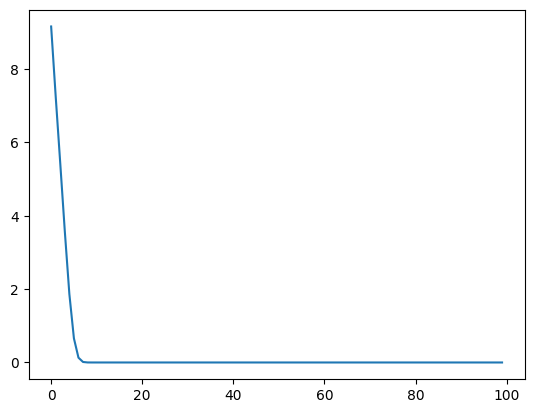

In [13]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

損失関数は最初誤差が大きかったですが、最終的に0に近づくのが確認できます。

